# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

We'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [1]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

!rm -rf /root/tensorflow_datasets/|

/bin/bash: -c: line 2: syntax error: unexpected end of file


In [2]:
%pip --no-cache-dir install tensorflow-datasets --user
%pip --no-cache-dir install tfds-nightly --user
%pip --no-cache-dir install --upgrade tensorflow --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 118.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 133.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 230.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 131.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 240.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 210.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


After the above installations have finished **be sure to restart the kernel**. You can do this by going to **Kernel > Restart**.

In [8]:
# Import TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

In [9]:
# TODO: Make all other necessary imports.
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import matplotlib.pyplot as plt



In [10]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [11]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [8]:
# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
# Load the Oxford Flowers 102 dataset
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

# Print dataset info
print(info)

# TODO: Create a training set, a validation set and a test set.

# Extract train, validation, and test sets
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']


tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

## Explore the Dataset

In [9]:
# TODO: Get the number of examples in each set from the dataset info.
num_train_examples = info.splits['train'].num_examples
num_validation_examples = info.splits['validation'].num_examples
num_test_examples = info.splits['test'].num_examples

print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_validation_examples}")
print(f"Number of test examples: {num_test_examples}")

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

Number of training examples: 1020
Number of validation examples: 1020
Number of test examples: 6149
Number of classes: 102


In [10]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
# Print the shape and corresponding label of 3 images in the training set
for image, label in train_dataset.take(3):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (500, 667, 3)
Label: 72
Image shape: (500, 666, 3)
Label: 84
Image shape: (670, 500, 3)
Label: 70


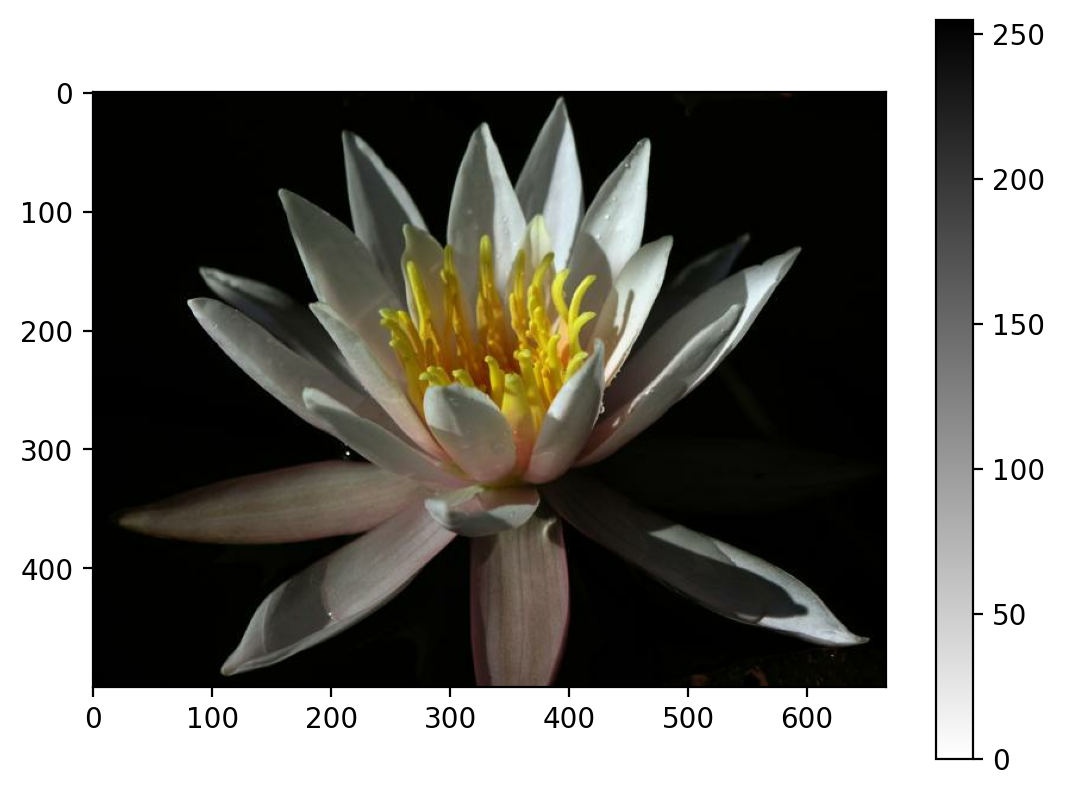

The label of this image is: 72


In [11]:
for image, label in train_dataset.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', label)


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [12]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [13]:
class_names

{'0': 'pink primrose',
 '1': 'hard-leaved pocket orchid',
 '2': 'canterbury bells',
 '3': 'sweet pea',
 '4': 'english marigold',
 '5': 'tiger lily',
 '6': 'moon orchid',
 '7': 'bird of paradise',
 '8': 'monkshood',
 '9': 'globe thistle',
 '10': 'snapdragon',
 '11': "colt's foot",
 '12': 'king protea',
 '13': 'spear thistle',
 '14': 'yellow iris',
 '15': 'globe-flower',
 '16': 'purple coneflower',
 '17': 'peruvian lily',
 '18': 'balloon flower',
 '19': 'giant white arum lily',
 '20': 'fire lily',
 '21': 'pincushion flower',
 '22': 'fritillary',
 '23': 'red ginger',
 '24': 'grape hyacinth',
 '25': 'corn poppy',
 '26': 'prince of wales feathers',
 '27': 'stemless gentian',
 '28': 'artichoke',
 '29': 'sweet william',
 '30': 'carnation',
 '31': 'garden phlox',
 '32': 'love in the mist',
 '33': 'mexican aster',
 '34': 'alpine sea holly',
 '35': 'ruby-lipped cattleya',
 '36': 'cape flower',
 '37': 'great masterwort',
 '38': 'siam tulip',
 '39': 'lenten rose',
 '40': 'barbeton daisy',
 '41': '

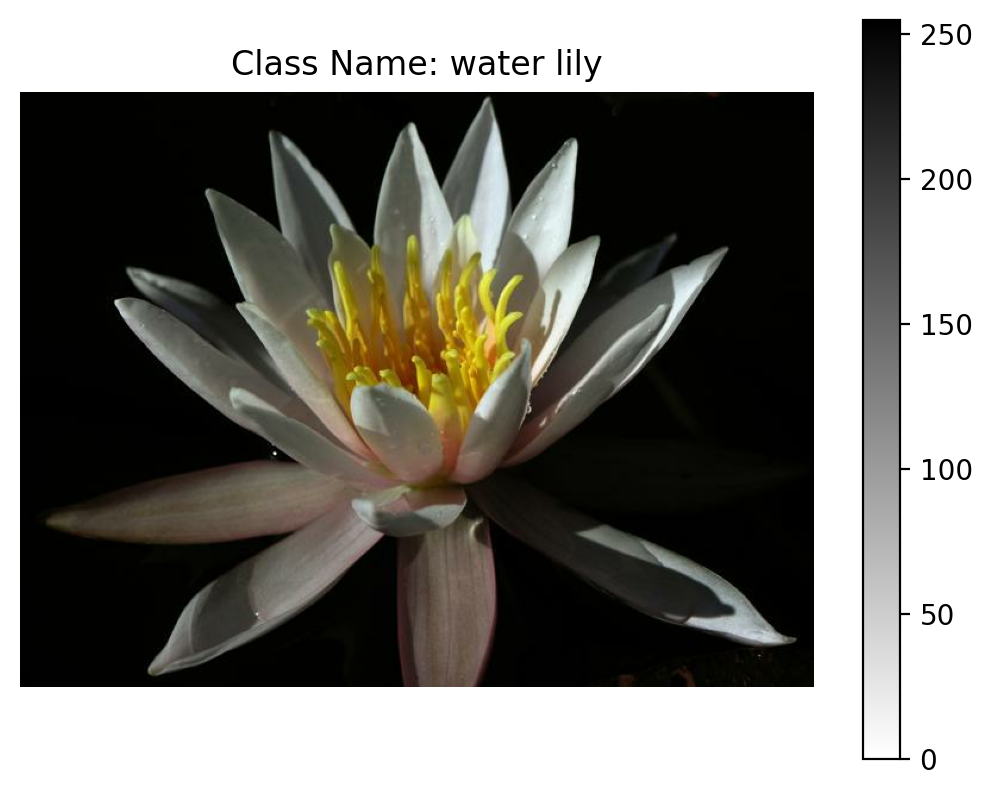

In [14]:
# TODO: Plot 1 image from the training set. Set the title

for image, label in train_dataset.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.title(f"Class Name: {class_names[str(label)]}")
plt.axis('off')
plt.show()


## Create Pipeline

In [41]:
# Constants
BATCH_SIZE = 32
IMG_SIZE = 224

# Function to preprocess and augment images for training
def preprocess_and_augment_train(image, label):
    # Resize the image to the desired size
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.2)

    # Normalize the image
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

# Function to preprocess images for validation and testing
def preprocess(image, label):
    # Resize the image to the desired size
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Normalize the image
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

# Prepare datasets
train_dataset = dataset['train'].map(preprocess_and_augment_train).shuffle(num_train_examples//4).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = dataset['validation'].map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

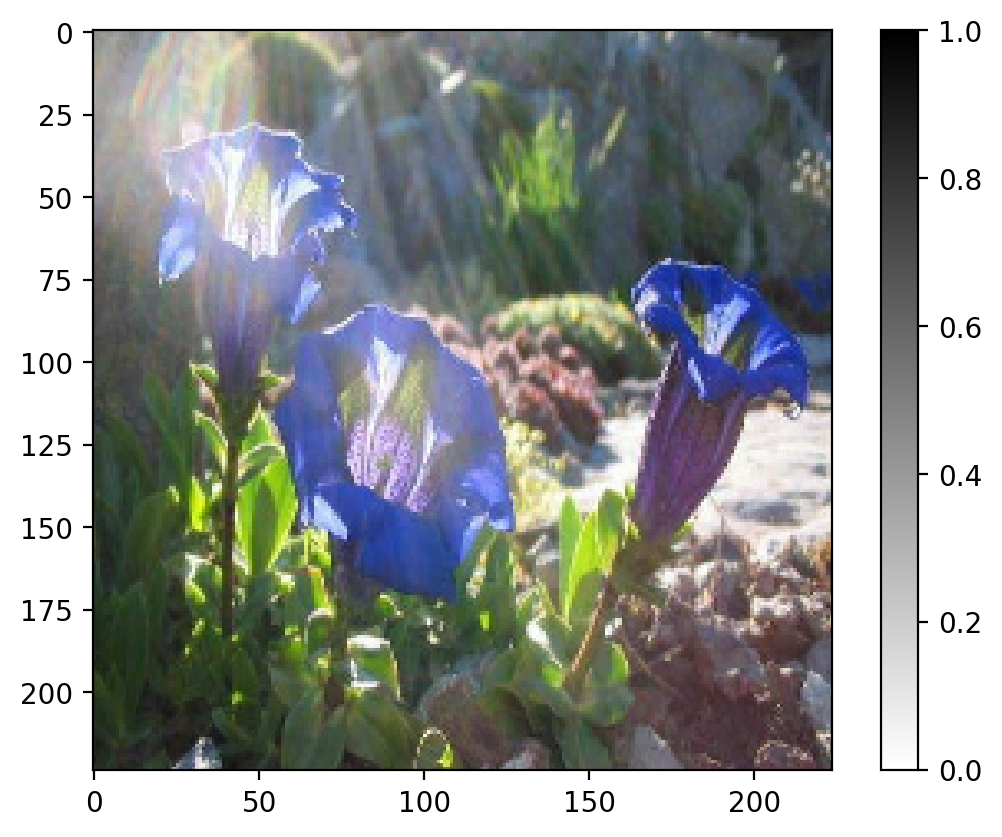

The label of this image is: 27


In [16]:
# of the plot to the corresponding class name.
# Take a single batch of images, and remove the color dimension by squeezing it
for image_batch, label_batch in training_batches.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

# Plot the image
plt.imshow(images[0], cmap = plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', labels[0])

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students!

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model.

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [42]:
# TODO: Build and train your network.

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

In [43]:
feature_extractor.trainable = False

In [44]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(102, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [46]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=10,
                    callbacks=[early_stopping])

Epoch 1/10
32/32 [==============================] - 13s 207ms/step - loss: 4.4503 - accuracy: 0.0941 - val_loss: 3.4100 - val_accuracy: 0.2706
Epoch 2/10
32/32 [==============================] - 6s 165ms/step - loss: 2.6741 - accuracy: 0.4676 - val_loss: 2.4428 - val_accuracy: 0.5039
Epoch 3/10
32/32 [==============================] - 7s 206ms/step - loss: 1.8113 - accuracy: 0.6765 - val_loss: 1.9237 - val_accuracy: 0.6147
Epoch 4/10
32/32 [==============================] - 6s 163ms/step - loss: 1.3214 - accuracy: 0.7775 - val_loss: 1.6559 - val_accuracy: 0.6775
Epoch 5/10
32/32 [==============================] - 7s 187ms/step - loss: 1.0090 - accuracy: 0.8500 - val_loss: 1.4651 - val_accuracy: 0.7118
Epoch 6/10
32/32 [==============================] - 7s 192ms/step - loss: 0.8149 - accuracy: 0.8882 - val_loss: 1.3260 - val_accuracy: 0.7225
Epoch 7/10
32/32 [==============================] - 10s 286ms/step - loss: 0.6832 - accuracy: 0.9010 - val_loss: 1.2268 - val_accuracy: 0.7353
Epoc

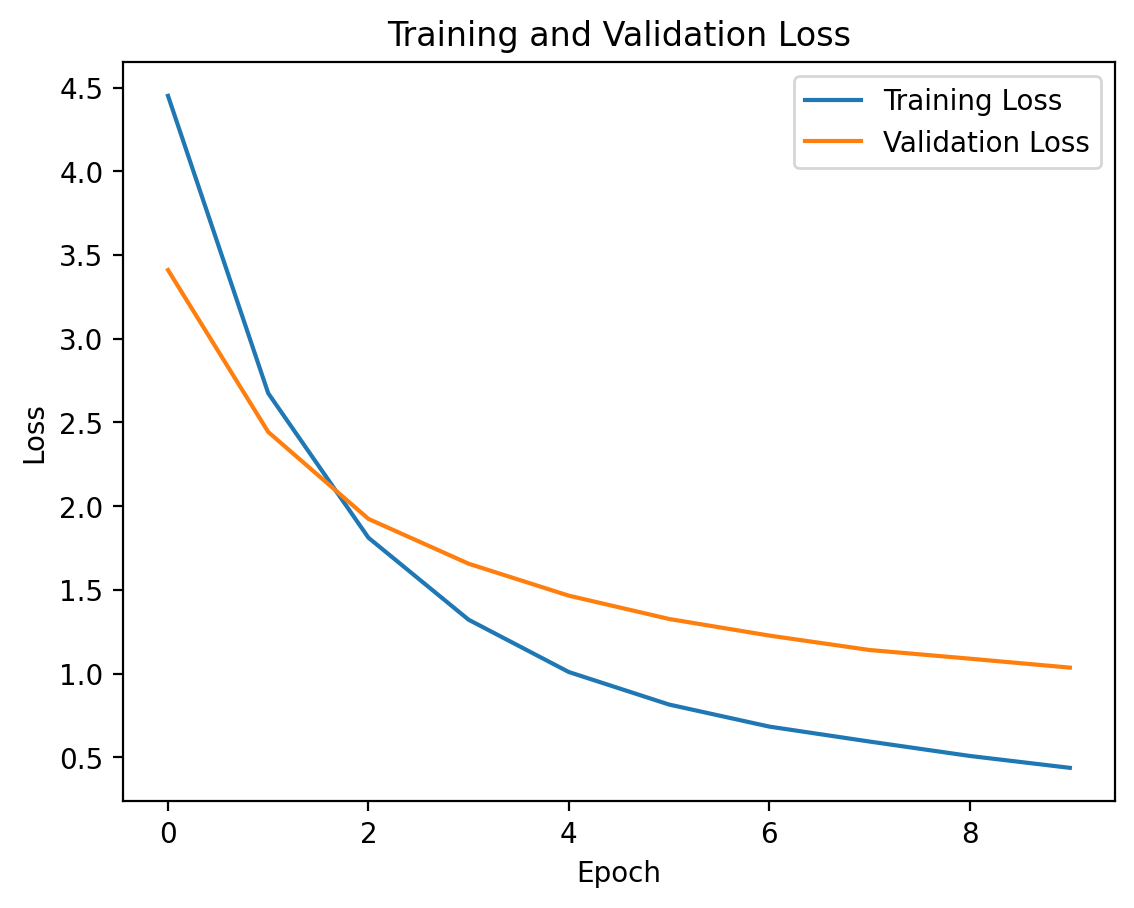

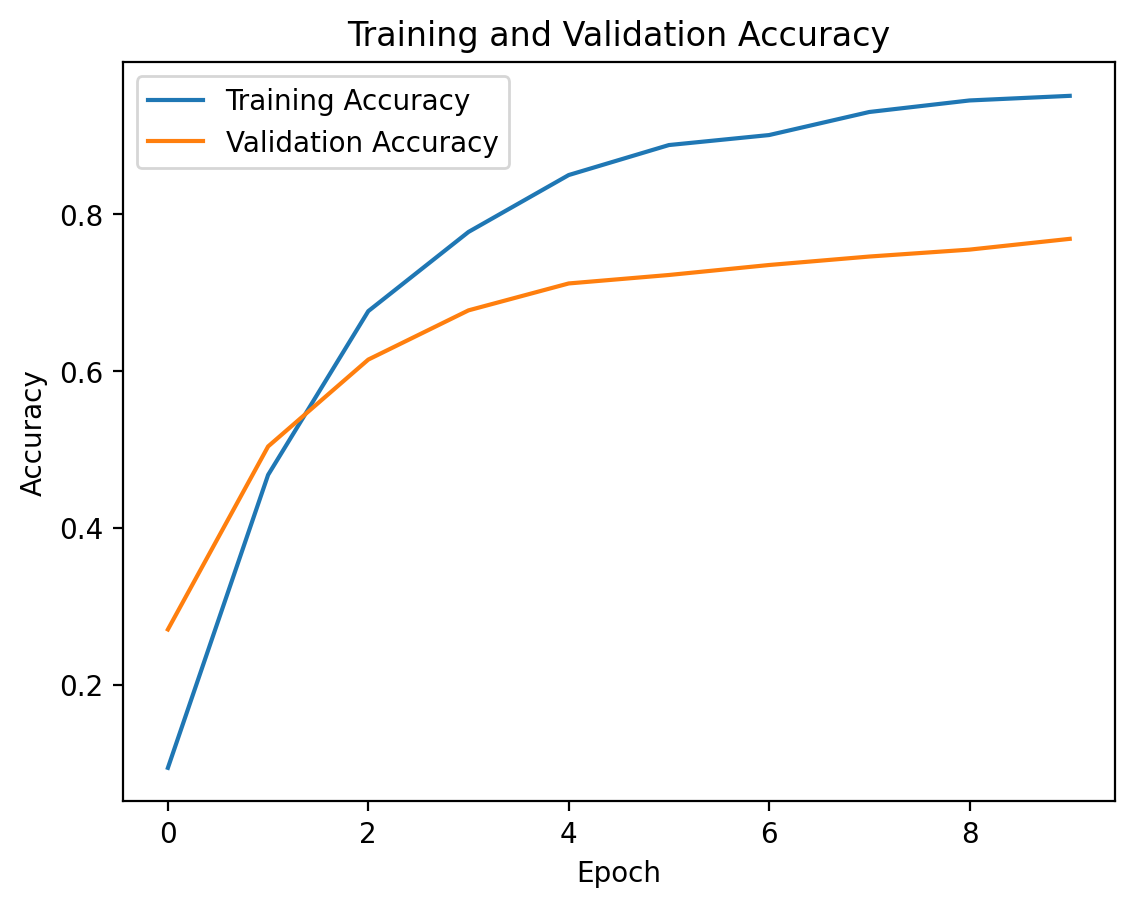

In [47]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [48]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")



193/193 [==============================] - 14s 73ms/step - loss: 1.1373 - accuracy: 0.7496
Test accuracy: 74.96%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [49]:
# TODO: Save your trained model as a Keras model.

# Save the model using the HDF5 format
model.save("flower_classification_model.h5")

print("Model saved successfully.")



Model saved successfully.


## Load the Keras Model

Load the Keras model you saved above.

In [12]:

# TODO: Load the Keras model
# Load the Keras model
loaded_model=tf.keras.models.load_model("flower_classification_model.h5",custom_objects={'KerasLayer':hub.KerasLayer})
#model = tf.keras.models.load_model('flower_classification_model.h5')

print("Model loaded successfully.")


ValueError: Unknown layer: 'KerasLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like:

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function.

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values.

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [36]:
# TODO: Create the process_image function


def process_image(image):

    # Convert image to TensorFlow Tensor
    image = tf.convert_to_tensor(image)

    # Resize image to 224x224 pixels
    image = tf.image.resize(image, (224, 224))

    # Normalize pixel values to [0, 1]
    image /= 255.0

    # Convert TensorFlow Tensor to NumPy array
    image = image.numpy()

    return image



To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size.

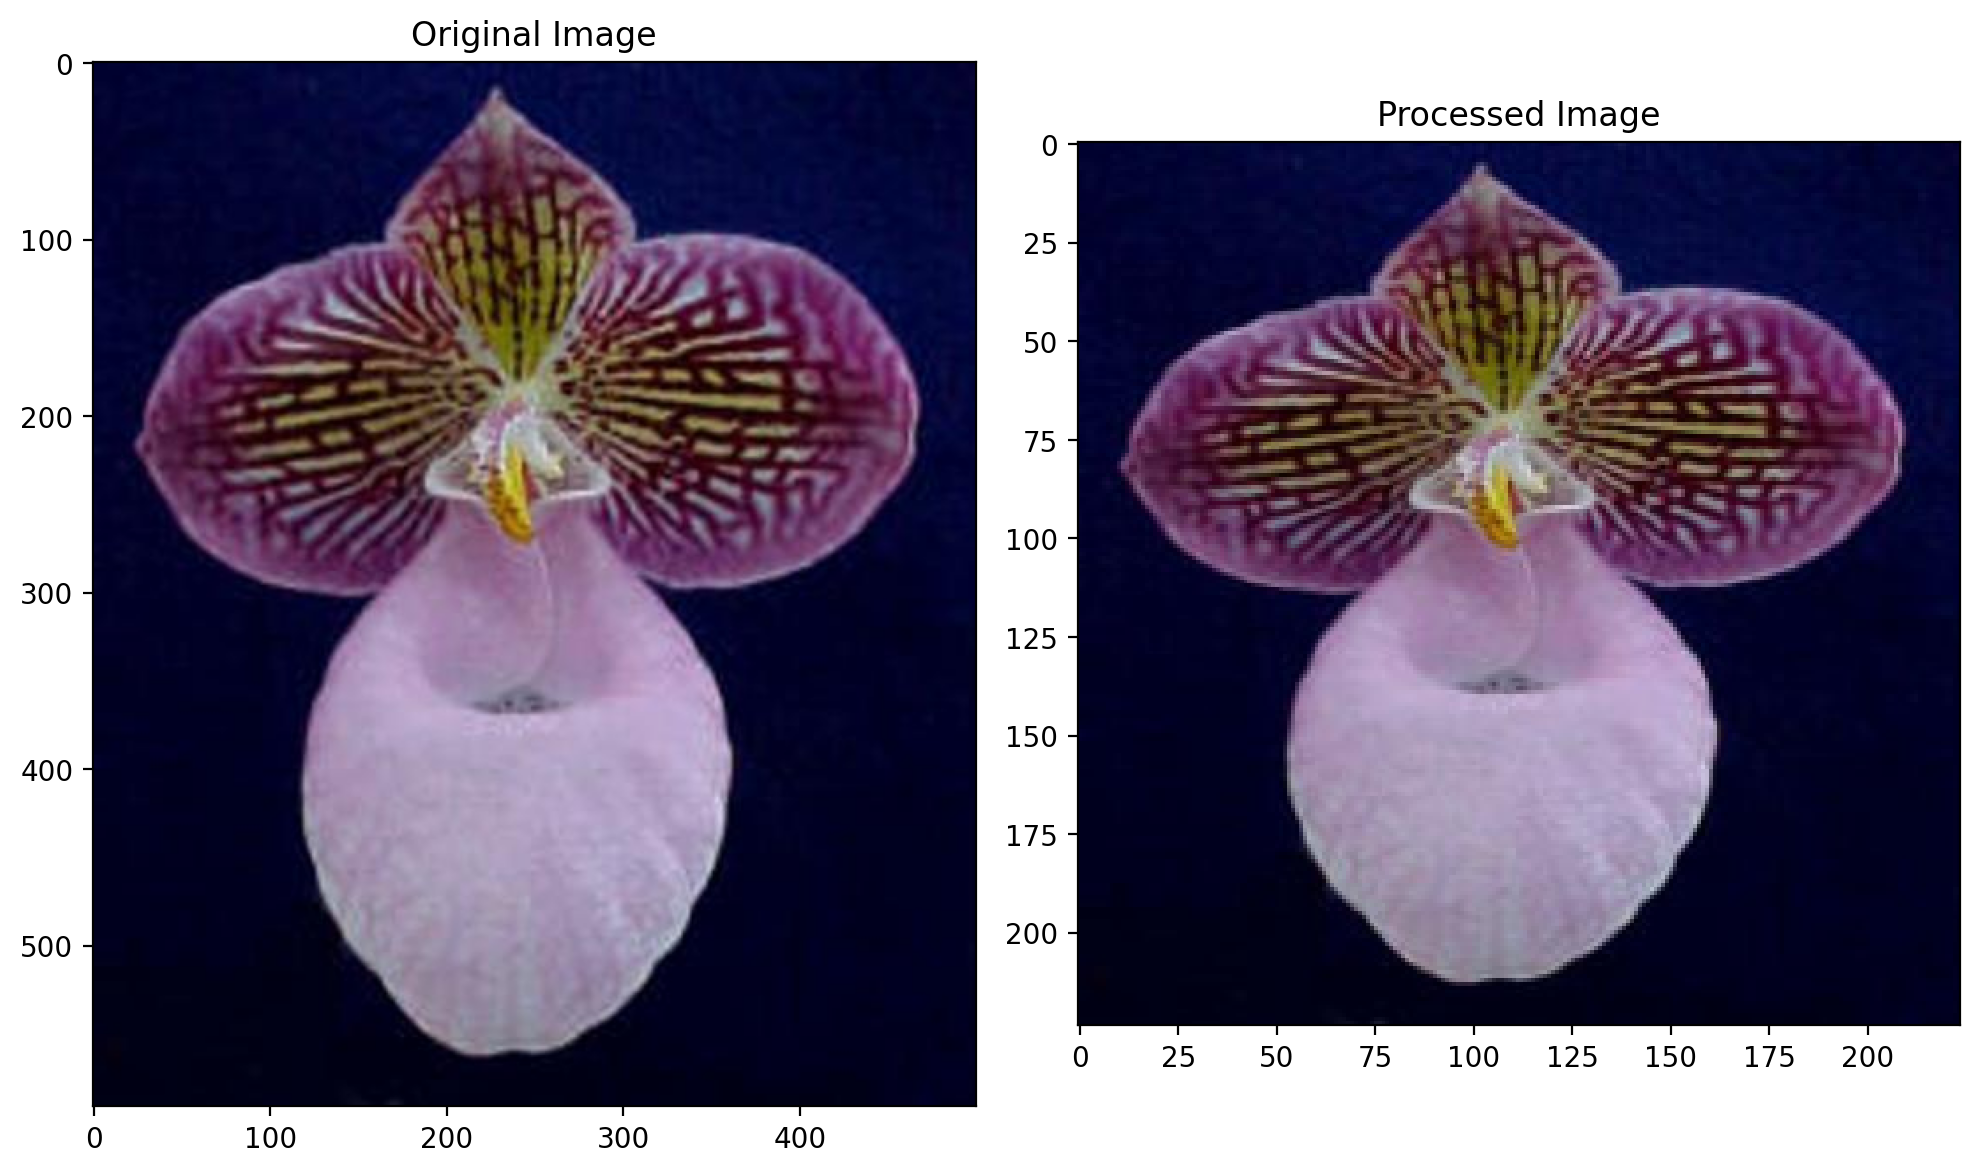

In [37]:


image_path = 'hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like:

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension.

In [38]:
# TODO: Create the predict function
def predict(image_path, model, top_k):

    # Load the image using PIL
    image = Image.open(image_path)

    # Preprocess the image
    processed_image = process_image(image)

    # Add batch dimension
    processed_image = np.expand_dims(processed_image, axis=0)

    # Predict probabilities
    predictions = model.predict(processed_image)

    # Get the top K probabilities and class labels
    top_indices = np.argsort(predictions[0])[-top_k:][::-1]
    probs = predictions[0][top_indices]
    classes = [str(index + 1) for index in top_indices]

    return probs, classes





# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`.

1/1 [==============================] - 1s 525ms/step


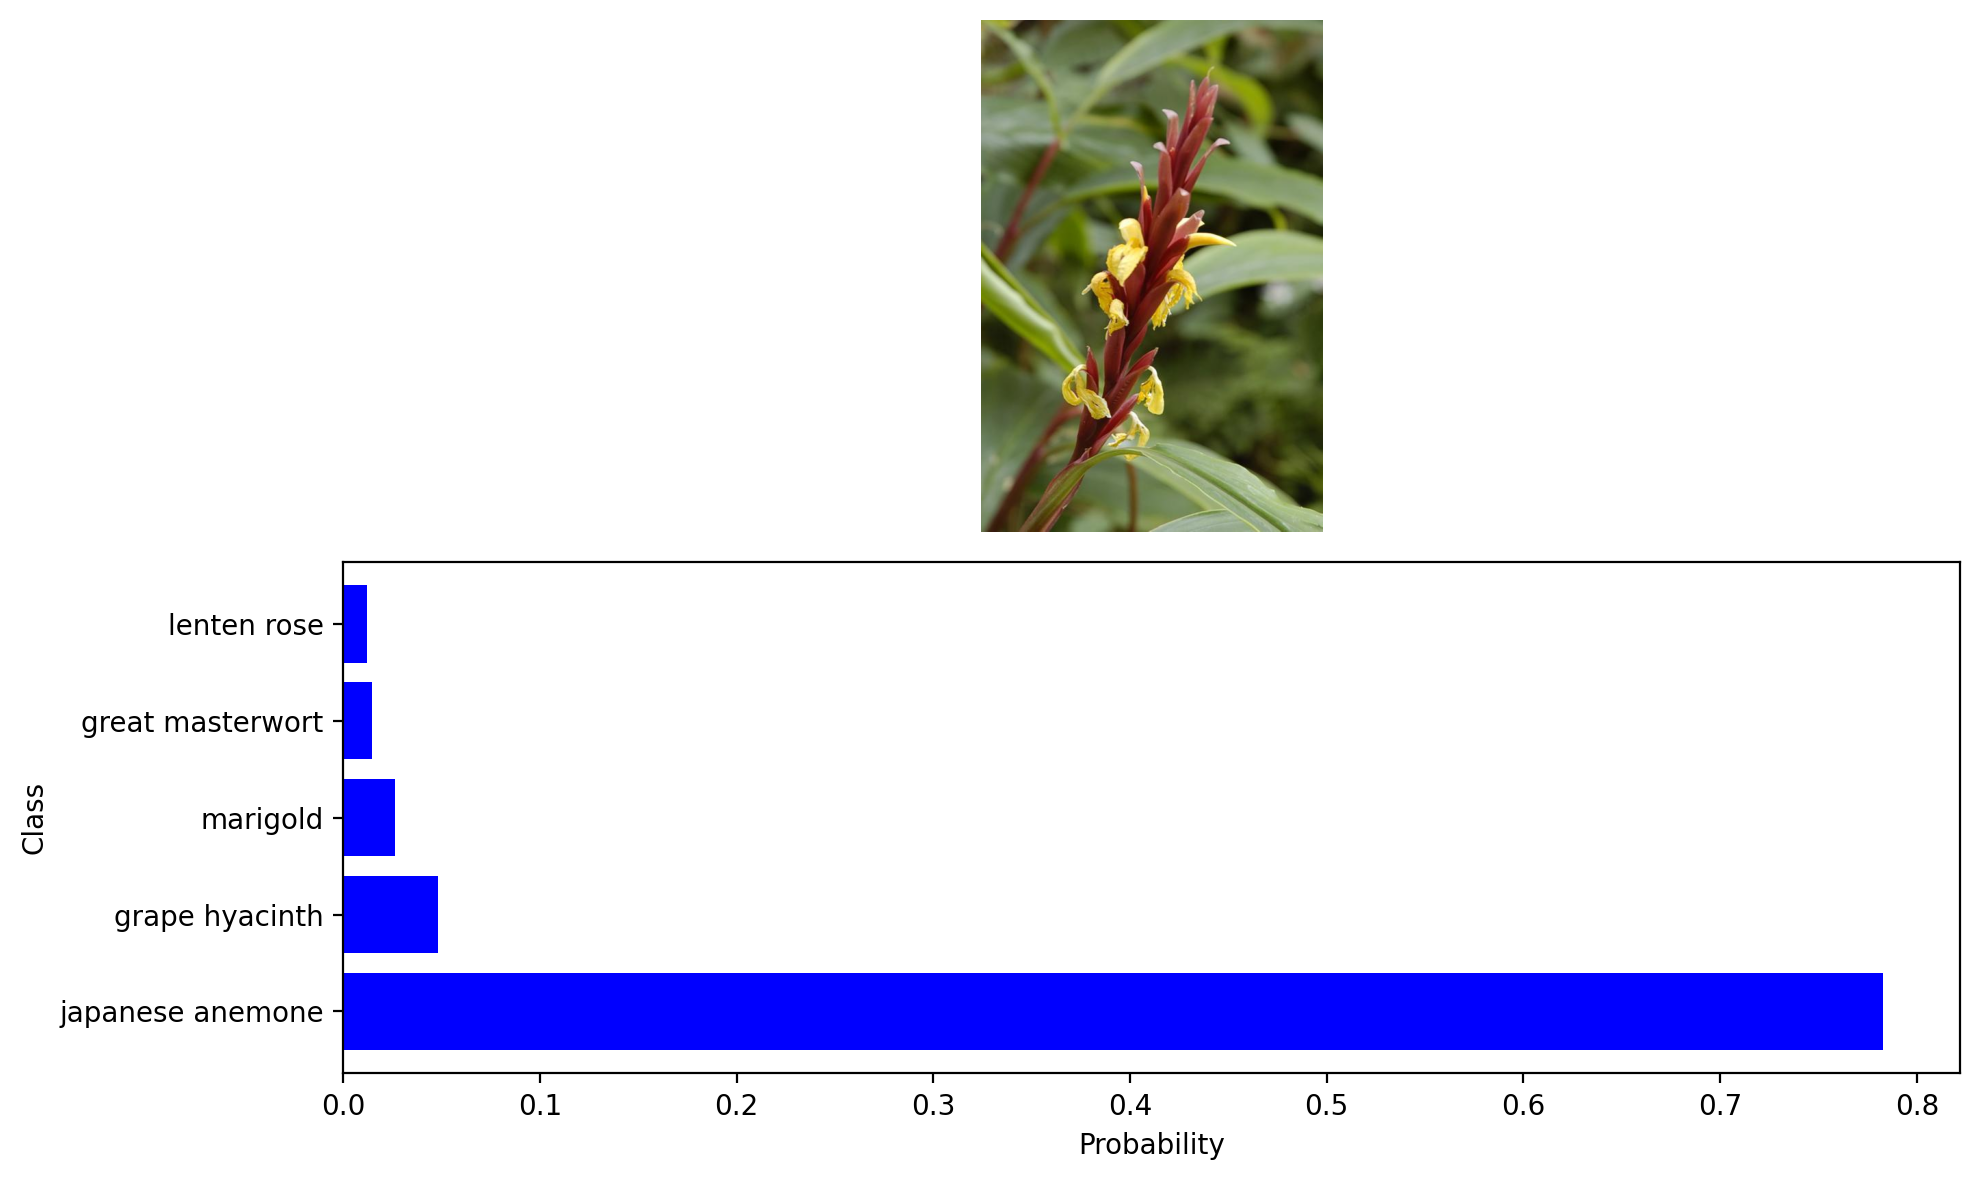

In [51]:
# TODO: Plot the input image along with the top 5 classes
def plot_image(image_path, model, class_names, top_k):
    # Predict probabilities and classes
    probs, classes = predict(image_path, model, top_k)

    # Load and display the image
    image = Image.open(image_path)
    plt.figure(figsize=(10, 6))  # Adjust the figure size
    plt.subplot(2, 1, 1)  # Plot the image in the first row
    plt.imshow(image)
    plt.axis('off')

    # Display the top K classes and probabilities
    class_names = [class_names[class_label] for class_label in classes]
    plt.subplot(2, 1, 2)  # Plot the bar chart in the second row
    plt.barh(np.arange(top_k), probs, color='blue')
    plt.yticks(np.arange(top_k), class_names)
    plt.xlabel('Probability')
    plt.ylabel('Class')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


# Plot the input image and top 5 classes
image_path = 'cautleya_spicata.jpg'
plot_image(image_path, loaded_model, class_names, top_k=5)

1/1 [==============================] - 0s 25ms/step


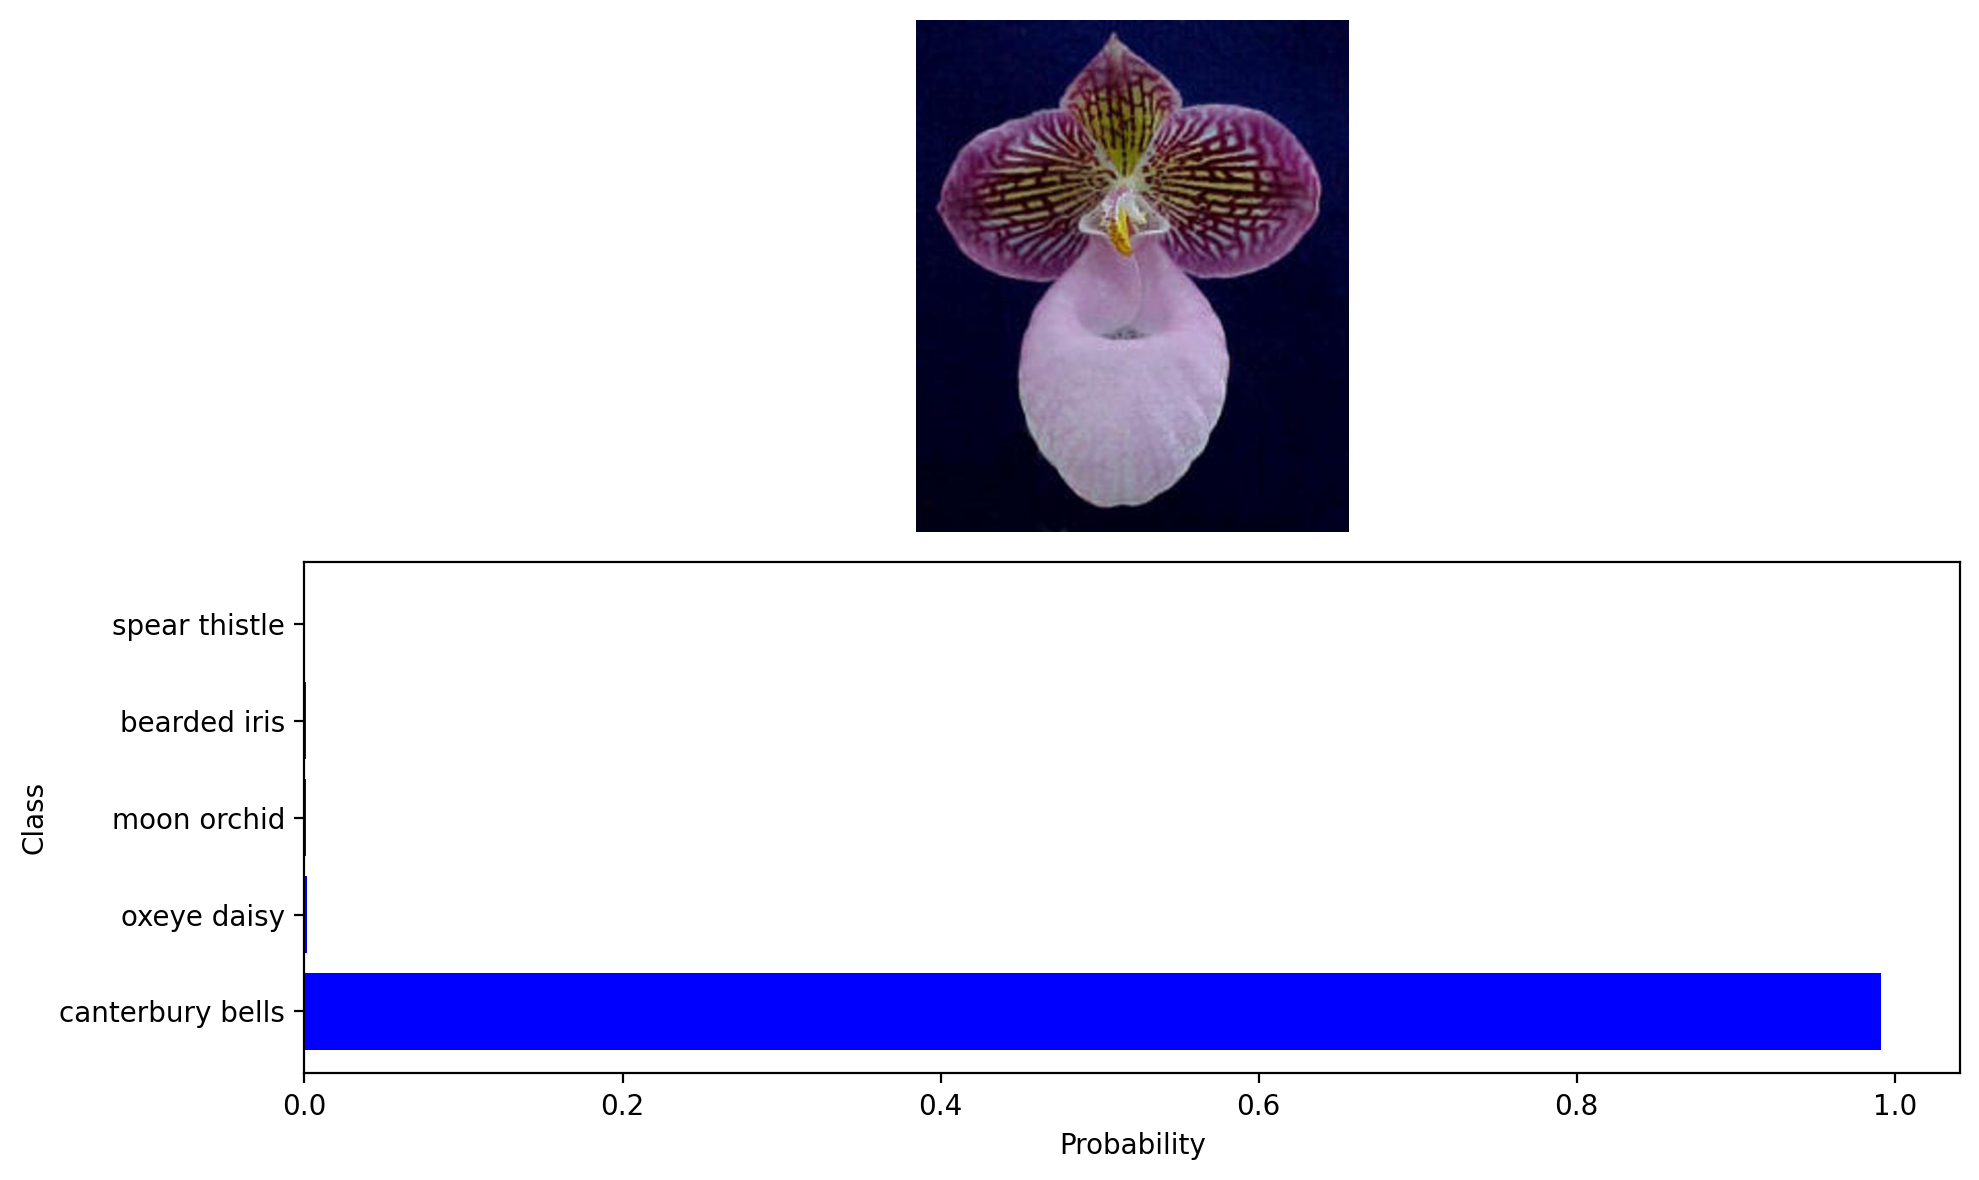

In [52]:
# Plot the input image and top 5 classes
image_path = 'hard-leaved_pocket_orchid.jpg'
plot_image(image_path, loaded_model, class_names, top_k=5)

1/1 [==============================] - 1s 816ms/step


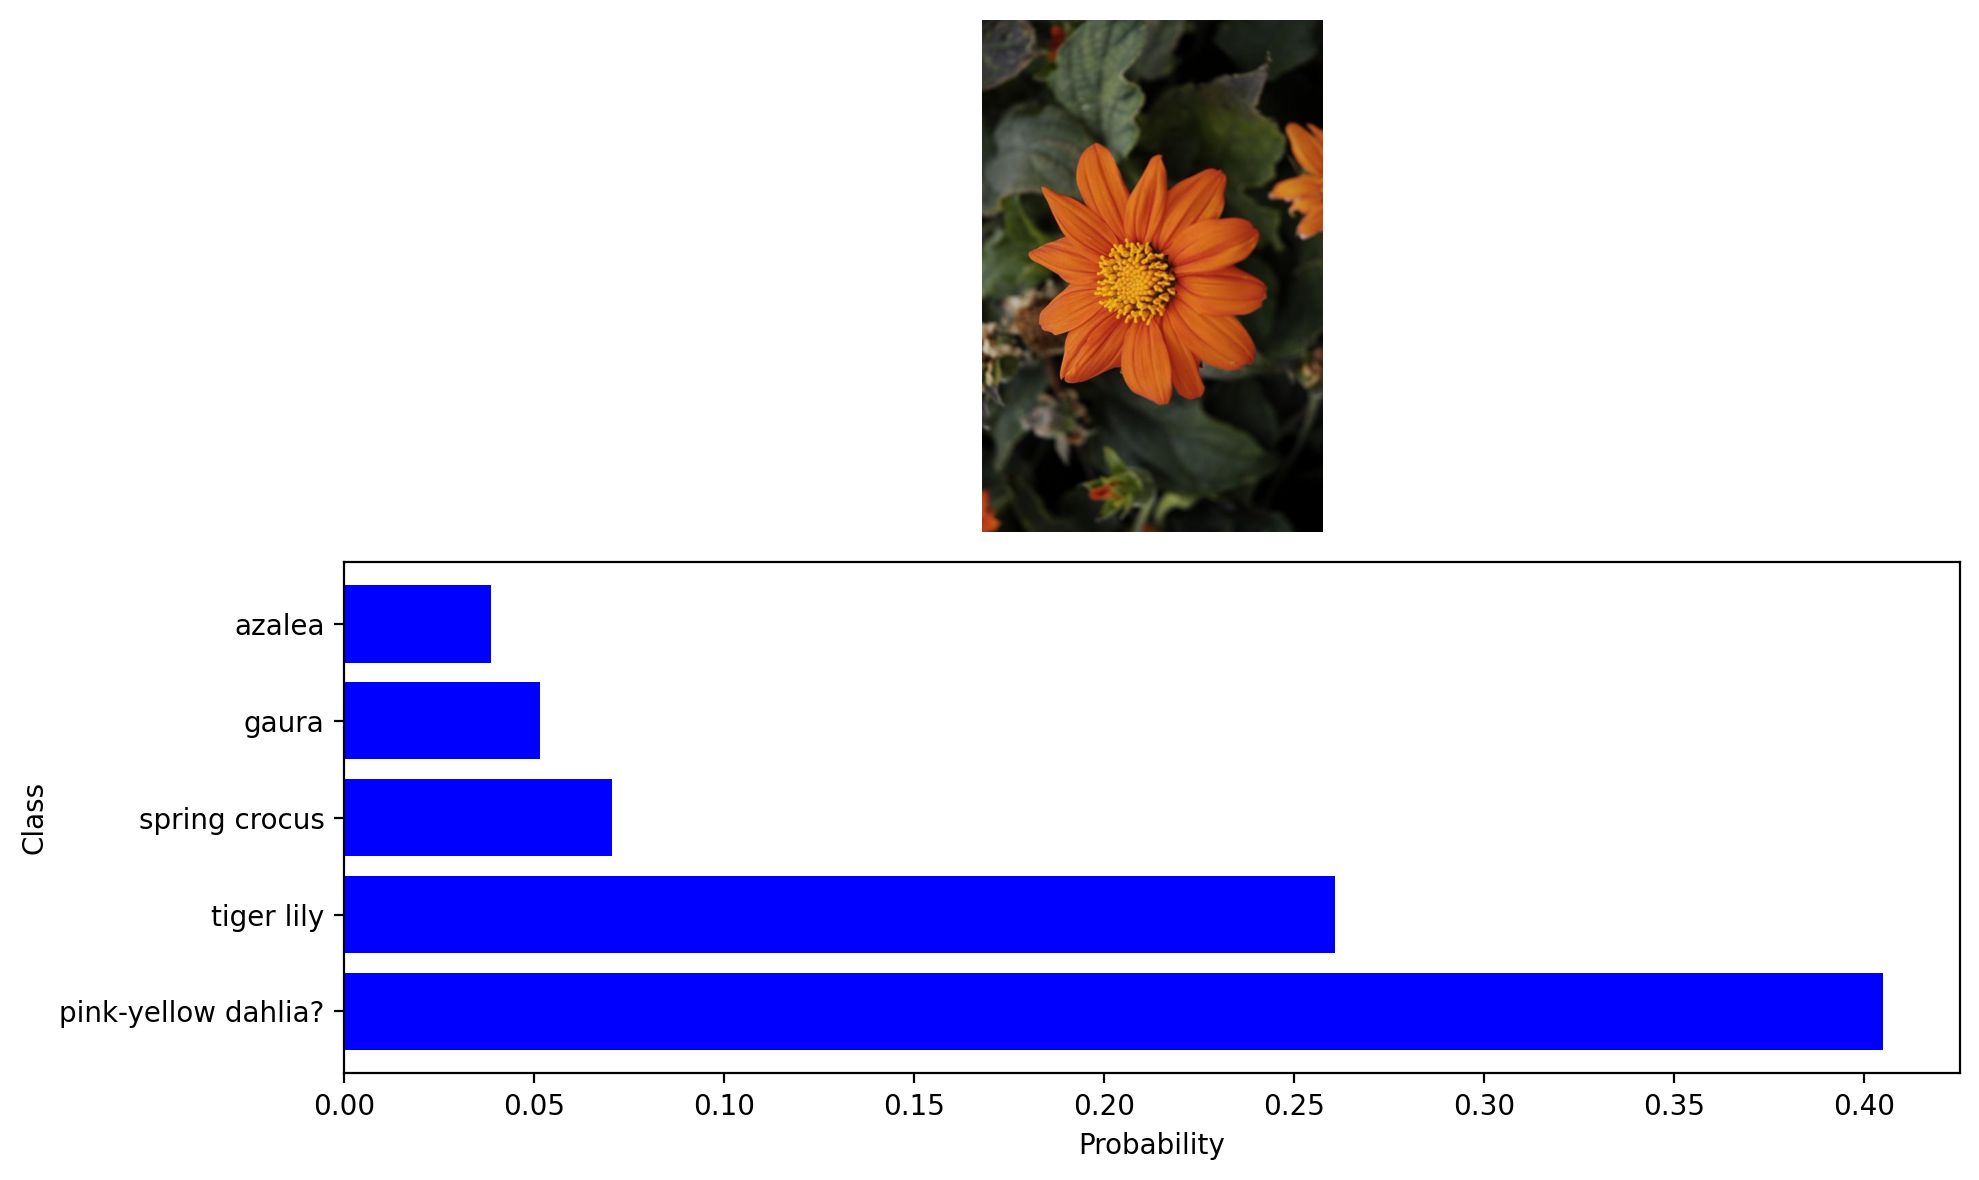

In [53]:
# Plot the input image and top 5 classes
image_path = 'orange_dahlia.jpg'
plot_image(image_path, model, class_names, top_k=5)

1/1 [==============================] - 0s 25ms/step


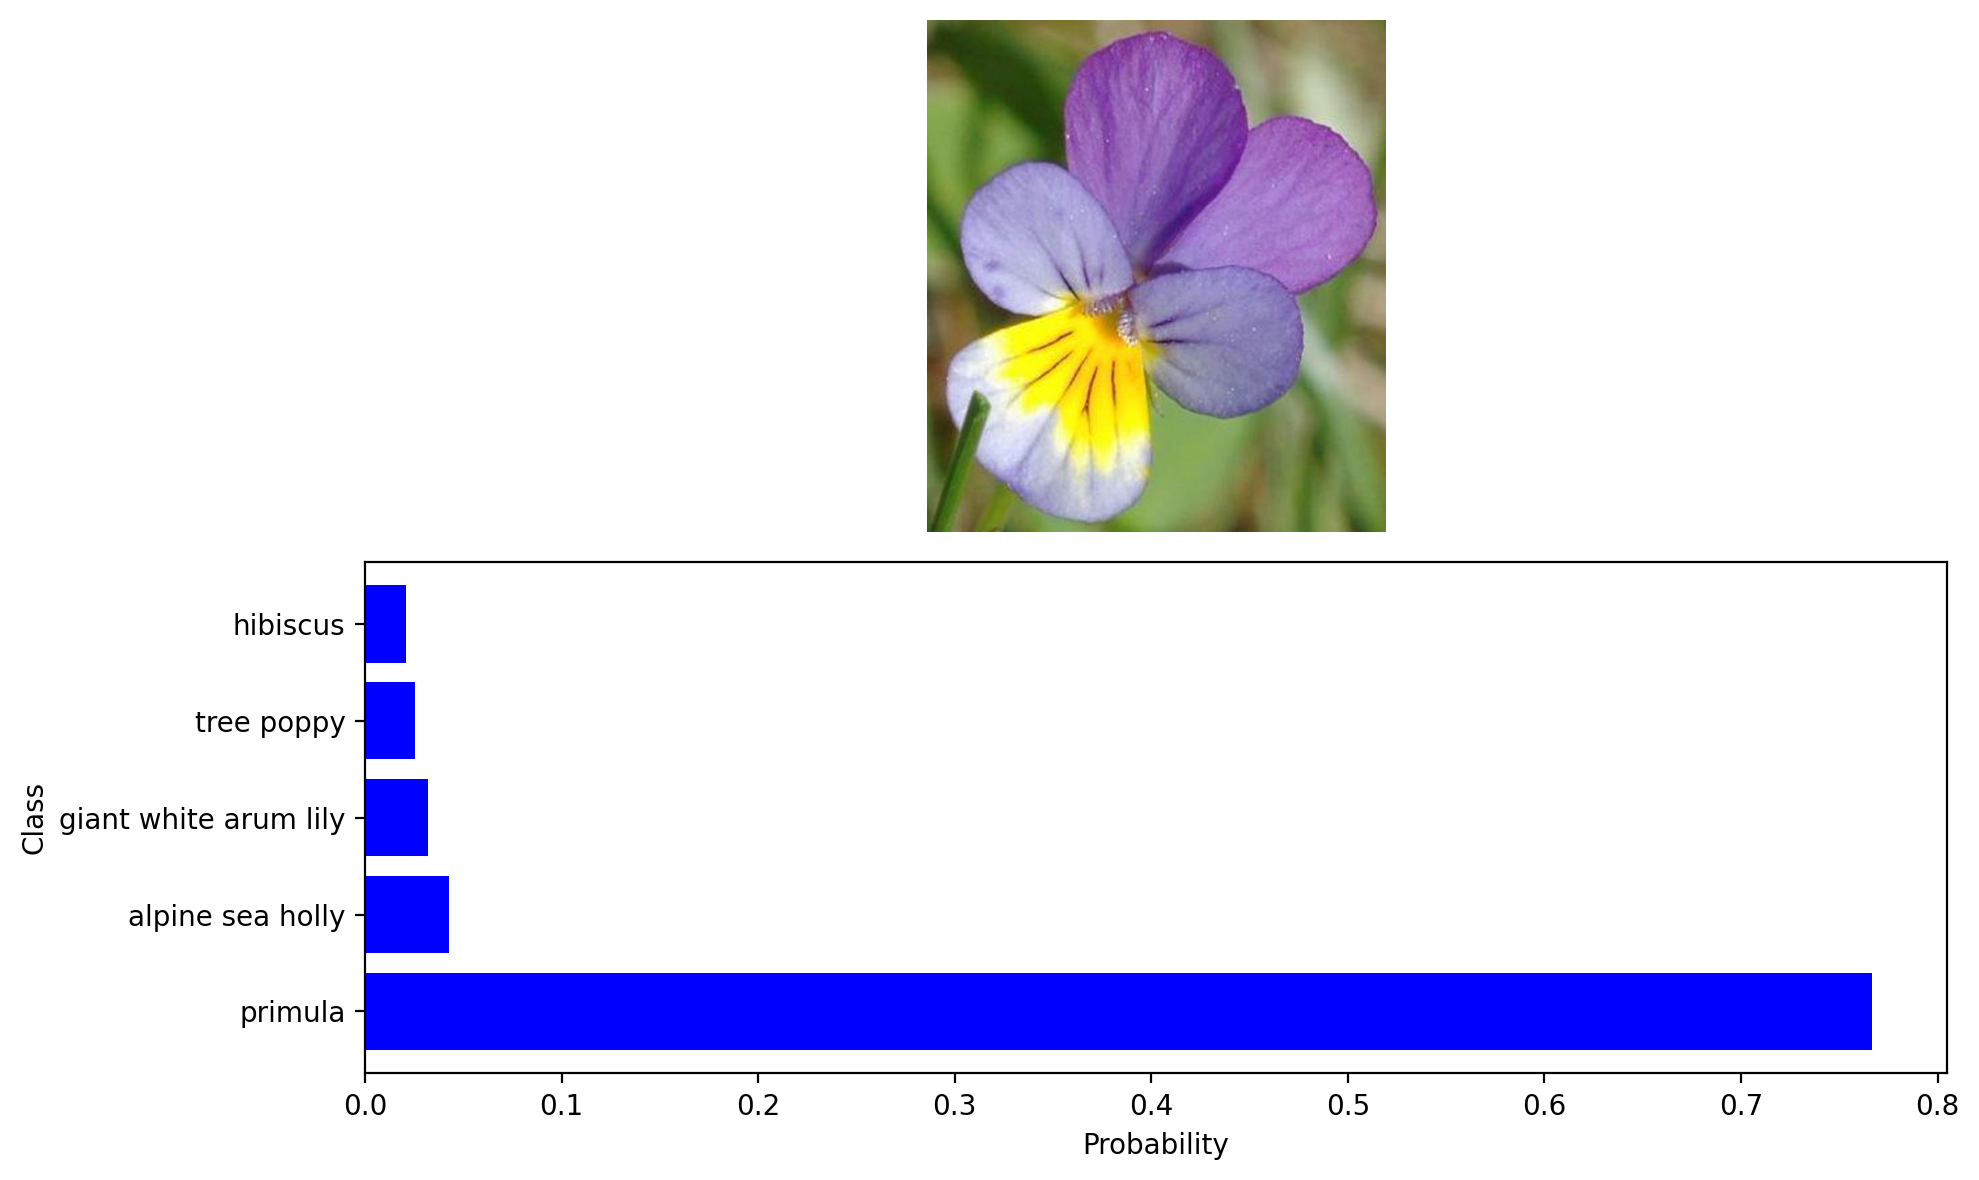

In [54]:
# Plot the input image and top 5 classes
image_path = 'wild_pansy.jpg'
plot_image(image_path, model, class_names, top_k=5)